## Import Packages

In [1]:
import cv2
import glob
from ipywidgets import interact
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pickle
from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import time
from tqdm import tqdm

# import additional packages to work with video files
from IPython.display import HTML
from moviepy.editor import VideoFileClip

%matplotlib inline

print('...')

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


...


## Explore Dataset

_**Note:** Before running the code below, download and unzip Udacity's vehicle.zip and non-vehicles.zip by running_ `./load_dataset.sh` _from command line_


In [2]:
# find and save all vehicle image and non-vehicle image file paths into list objects
vehicle_img_fpaths = glob.glob('dataset/vehicles/**/*.png')
non_vehicle_img_fpaths = glob.glob('dataset/non-vehicles/**/*.png')

print('...')

...


In [3]:
# get number of vehicle images and non-vehicle images
print("Number of vehicle images: {} \nNumber of non-vehicle images: {}".format(len(vehicle_img_fpaths), 
                                                                               len(non_vehicle_img_fpaths)))

Number of vehicle images: 8792 
Number of non-vehicle images: 8968


In [4]:
# get shape of vehicle and non-vehicle iamges
example_vehicle_img = mpimg.imread(vehicle_img_fpaths[0])
example_non_vehicle_img = mpimg.imread(non_vehicle_img_fpaths[0])
print("Shape of example vehicle image: {} \nShape of example non-vehicle images: {}".format(
    example_vehicle_img.shape, example_non_vehicle_img.shape))

Shape of example vehicle image: (64, 64, 3) 
Shape of example non-vehicle images: (64, 64, 3)


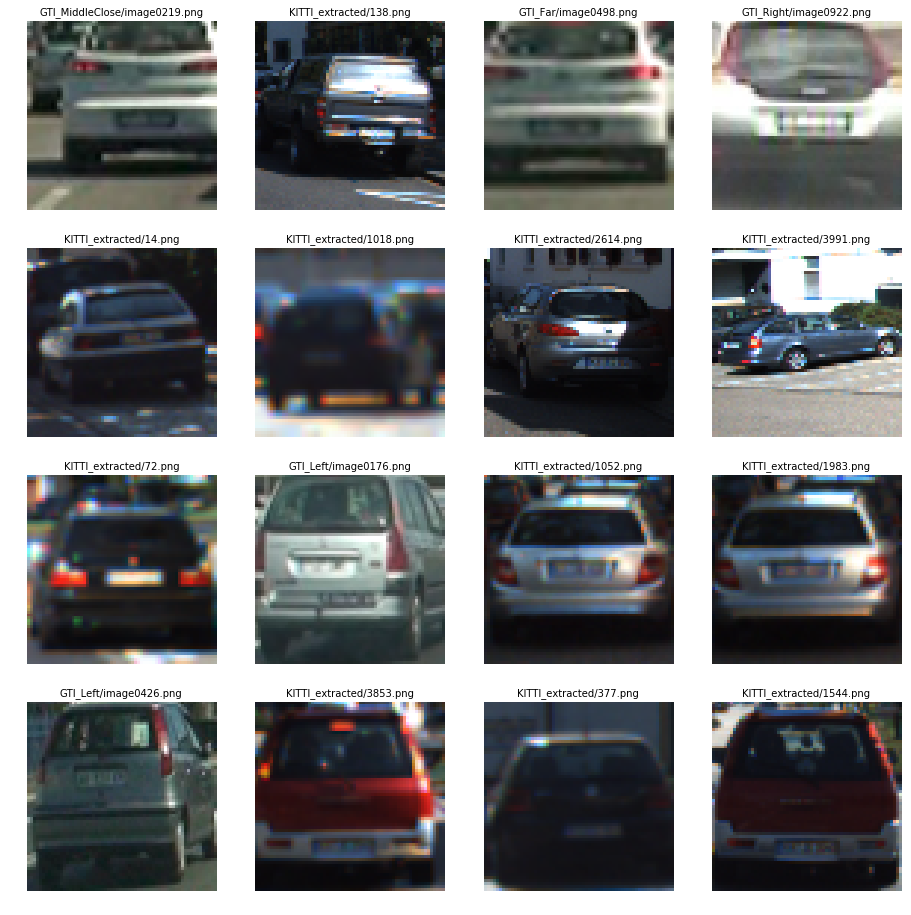

In [5]:
# visualize random selection of 16 vehicle images
fig, axes = plt.subplots(4,4, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.1)
axes = axes.ravel()

for i in np.arange(16):
    vehicle_img_fpath = vehicle_img_fpaths[np.random.randint(0,len(vehicle_img_fpaths))]
    vehicle_img_title = os.path.join(vehicle_img_fpath.split('/')[2], vehicle_img_fpath.split('/')[3])
    img = mpimg.imread(vehicle_img_fpath)
    axes[i].axis('off')
    axes[i].set_title(vehicle_img_title, fontsize=10)
    axes[i].imshow(img)

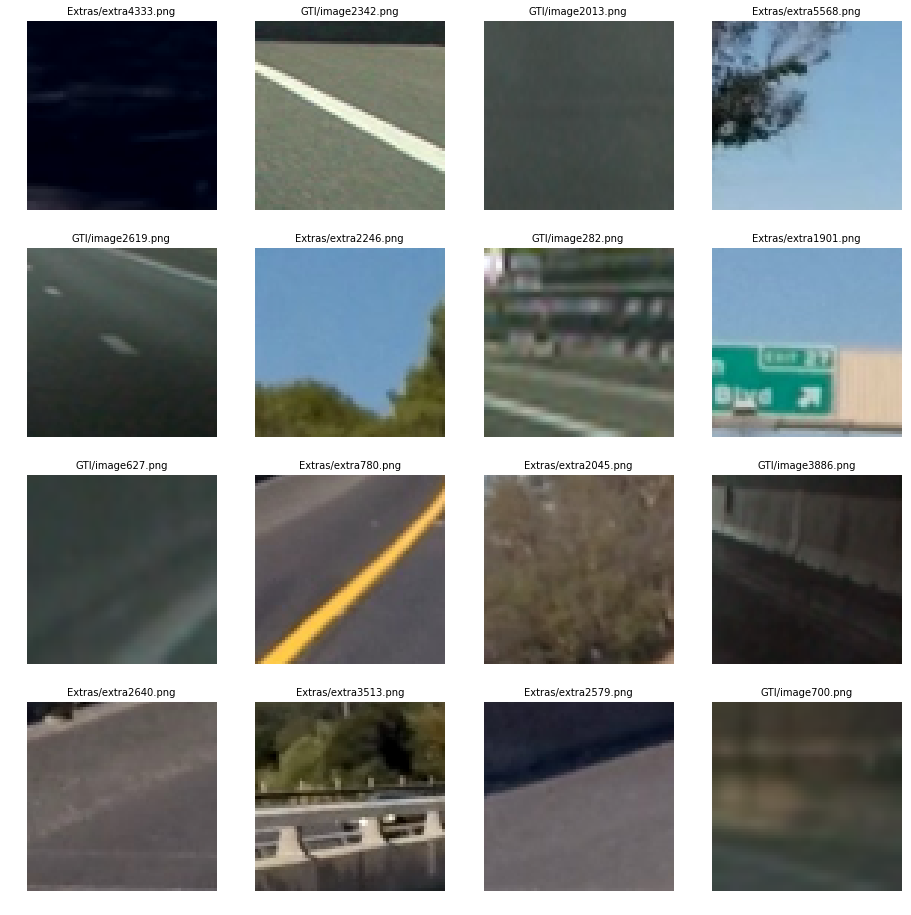

In [6]:
# visualize random selection of 16 non-vehicle images
fig, axes = plt.subplots(4,4, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.1)
axes = axes.ravel()

for i in np.arange(16):
    non_vehicle_img_fpath = non_vehicle_img_fpaths[np.random.randint(0,len(non_vehicle_img_fpaths))]
    non_vehicle_img_title = os.path.join(non_vehicle_img_fpath.split('/')[2], non_vehicle_img_fpath.split('/')[3])
    img = mpimg.imread(non_vehicle_img_fpath)
    axes[i].axis('off')
    axes[i].set_title(non_vehicle_img_title, fontsize=10)
    axes[i].imshow(img)

## Display Histogram of Oriented Gradients (HOG) on Example Images

In [7]:
# function provided on Udacity's course
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

print('...')

...


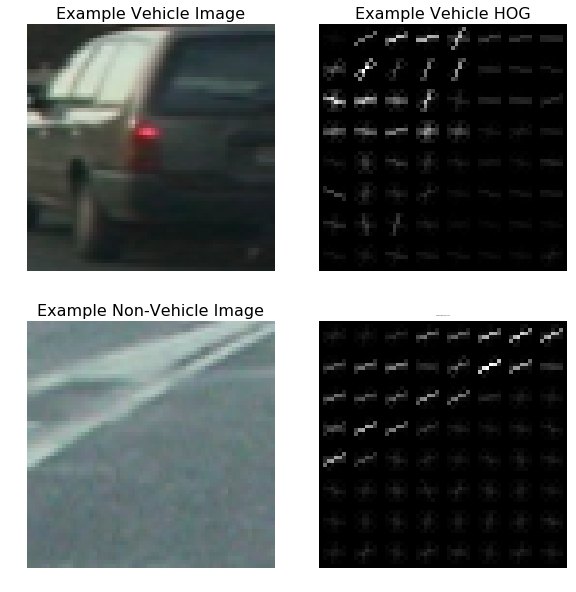

In [8]:
example_vehicle_img = mpimg.imread(vehicle_img_fpaths[np.random.randint(0,len(vehicle_img_fpaths))])
example_non_vehicle_img = mpimg.imread(non_vehicle_img_fpaths[np.random.randint(0,len(non_vehicle_img_fpaths))])

_, example_vehicle_hog = get_hog_features(example_vehicle_img, 
                                          orient = 8, 
                                          pix_per_cell = 8, 
                                          cell_per_block = 2,
                                          vis=True, 
                                          feature_vec=True)

_, example_non_vehicle_hog = get_hog_features(example_non_vehicle_img, 
                                          orient = 8, 
                                          pix_per_cell = 8, 
                                          cell_per_block = 2,
                                          vis=True, 
                                          feature_vec=True)


fig, axes = plt.subplots(2,2, figsize=(10, 10))
fig.subplots_adjust(hspace = .2, wspace=.1)
axes = axes.ravel()

for i in range(4):
    axes[i].axis('off')  
    
axes[0].imshow(example_vehicle_img)
axes[0].set_title('Example Vehicle Image', fontsize = 16)
axes[1].imshow(example_vehicle_hog, cmap = 'gray')
axes[1].set_title('Example Vehicle HOG', fontsize = 16)
axes[2].imshow(example_non_vehicle_img)
axes[2].set_title('Example Non-Vehicle Image', fontsize = 16)
axes[3].imshow(example_non_vehicle_hog, cmap = 'gray')
axes[3].set_title('Example Non-Vehicle HOG', fontsize = 1)

## Explore HOG Parameters

In [9]:
def fiddle_with_hog_params(orients = 8, pxs_per_cell = 8, cells_per_block = 2):
    """
    Serves as input to ipywidgets.interact() allowing to explore impact of number of orientations 'orients', 
    number of pixels in x- and y-direction per cell 'pxs_per_cell', 
    and number of cells in x- and y-direction per block 'cells_per_block'
    on output hog image.
    Displays original vehicle and non-vehicle image alongside respective HOG images
    """
    example_vehicle_img = mpimg.imread(vehicle_img_fpaths[0])
    example_non_vehicle_img = mpimg.imread(non_vehicle_img_fpaths[0])

    _, example_vehicle_hog = get_hog_features(example_vehicle_img, 
                                              orient = orients, 
                                              pix_per_cell = pxs_per_cell, 
                                              cell_per_block = cells_per_block,
                                              vis=True, 
                                              feature_vec=True)

    _, example_non_vehicle_hog = get_hog_features(example_non_vehicle_img, 
                                              orient = orients, 
                                              pix_per_cell = pxs_per_cell, 
                                              cell_per_block = cells_per_block,
                                              vis=True, 
                                              feature_vec=True)


    fig, axes = plt.subplots(2,2, figsize=(10, 10))
    fig.subplots_adjust(hspace = .2, wspace=.1)
    axes = axes.ravel()

    for i in range(4):
        axes[i].axis('off')  

    axes[0].imshow(example_vehicle_img)
    axes[0].set_title('Example Vehicle Image', fontsize = 16)
    axes[1].imshow(example_vehicle_hog, cmap = 'gray')
    axes[1].set_title('Example Vehicle HOG', fontsize = 16)
    axes[2].imshow(example_non_vehicle_img)
    axes[2].set_title('Example Non-Vehicle Image', fontsize = 16)
    axes[3].imshow(example_non_vehicle_hog, cmap = 'gray')
    axes[3].set_title('Example Non-Vehicle HOG', fontsize = 1)

<function __main__.fiddle_with_hog_params(orients=8, pxs_per_cell=8, cells_per_block=2)>

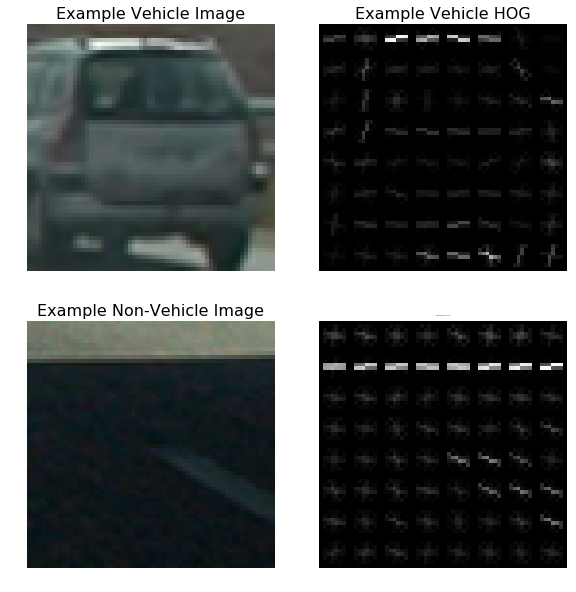

In [10]:
interact(fiddle_with_hog_params,
         orients = (0,16,1),
         pxs_per_cell = (4,16,2),
         cells_per_block = (2,4,1))

## Extract Features

In [11]:
# functions and class in this cell provided on Udacity's course

def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

class FeaturesParameters():
    def __init__(self):
        # HOG parameters
        self.cspace = 'YCrCb'
        self.orient = 8
        self.pix_per_cell = 8
        self.cell_per_block = 2
        self.hog_channel = 'ALL'
        # Bin spatial parameters
        self.size = (16, 16)
        # Histogram parameters
        self.hist_bins = 32
        self.hist_range = (0, 256)
        
def extract_features(image, params):
    # Parameters extraction
    # HOG parameters
    cspace = params.cspace
    orient = params.orient
    pix_per_cell = params.pix_per_cell
    cell_per_block = params.cell_per_block
    hog_channel = params.hog_channel
    # Spatial parameters
    size = params.size
    # Histogram parameters
    hist_bins = params.hist_bins
    hist_range = params.hist_range
    
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)

    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, size)

    # Apply color_hist() 
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    
    return np.concatenate((spatial_features, hist_features, hog_features))

print('...')

...


In [16]:
def load_images(img_fpaths, img_type_str):
    """
    Takes as input a list of image file paths 'img_fpaths',
    and a string specifing which type of images are loaded 'img_type_str'.
    Shows progress bar while reading them one by one, 
    and returns list of loaded rgb images / np.arrays 'imgs_list'
    """
    imgs_list = []
    
    with tqdm(total=len(img_fpaths)) as pbar:
        for fpath in img_fpaths:
            pbar.set_description("Loading {} images".format(img_type_str))
            imgs_list.append(cv2.cvtColor(cv2.imread(fpath), cv2.COLOR_BGR2RGB))
            pbar.update(1)
    
    return imgs_list

print('...')

...


In [13]:
vehicle_imgs_list = load_images(vehicle_img_fpaths[0], 'vehicle')  
non_vehicle_imgs_list = load_images(non_vehicle_img_fpaths[0], 'non-vehicle')

Loading non-vehicle images: 100%|██████████| 8968/8968 [03:00<00:00, 49.70it/s]


In [41]:
def get_features_list(imgs_list, params, img_type_str):
    """
    Takes as input a list of loaded images 'img_list',
    instance of class FeaturesParameters including all parameters for feature extraction 'params',
    and a string specifing which type of images are loaded 'image_type_str'.
    Shows progress bar while extracting features per image, 
    and returns list of extracted features 'features_list'
    """
    features_list = []
    
    with tqdm(total=len(imgs_list)) as pbar:
        for img in imgs_list:
            pbar.set_description("Extracting {} features".format(img_type_str))
            features_list.append(extract_features(img, params))
            pbar.update(1)
    
    return features_list

print('...')

...


In [ ]:
params = FeaturesParameters()
vehicle_features = get_features_list(vehicle_imgs_list, params, 'vehicle')
non_vehicle_features = get_features_list(non_vehicle_imgs_list, params, 'non-vehicle')

Extracting non-vehicle features:  89%|████████▉ | 7964/8968 [02:28<00:20, 48.74it/s]